In [1]:
import os
print(os.getcwd())


/home/lee-ostadi/Point-Cloud-Autoencoder


In [2]:

import os
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from RGB_utils import utils
from RGB_model import model
from RGB_Dataloaders import GetDataLoaders




%matplotlib inline

import RGB_model as model


#from geomloss import SamplesLoss



In [3]:
#Note to self: I changed the fig_count to 2 
#and am doing normalizing instead of padding for constant 
#number of points 

In [4]:
#config
batch_size = 32
output_folder = os.path.expanduser("~/meoutputs1/") # folder path to save the results
save_results = True # save the results to output_folder
use_GPU = True # use GPU, False to use CPU
latent_size = 128 # bottleneck size of the Autoencoder model
train_source = 'data/toilet_adjusted.npy'
test_source = 'data/toilet_adjusted.npy'

In [5]:
from RGB_Dataloaders import GetDataLoaders

pc_array = np.load("data/toilet.npy", allow_pickle=True)
print(pc_array.shape)
###################################pad fct#######################################################
#if point clouds have varying sizes, pad them to a fixed size ((e.g., )1024 points)
#def pad_point_clouds(pc_list, fixed_size=1024):
#   padded_pc = []
#   for pc in pc_list:
#       num_points = pc.shape[0]
#       if num_points < fixed_size:
#           # Pad with zeros
#           padding = np.zeros((fixed_size - num_points, 3))
#           padded = np.vstack((pc, padding))
#       elif num_points > fixed_size:
#           # Truncate to fixed_size
#           padded = pc[:fixed_size, :]
#       else:
#           padded = pc
#       padded_pc.append(padded)
#   return np.array(padded_pc)
####################################selection fct#######################################################3

import numpy as np

def adjust_point_clouds(pc_list, fixed_size=1028):
    adjusted_pc = []
    for pc in pc_list:
        num_points = pc.shape[0]
        if num_points < fixed_size:
            # Upsample by randomly duplicating points
            indices = np.random.choice(num_points, fixed_size - num_points, replace=True)
            upsampled_points = pc[indices, :]
            adjusted_pc_single = np.vstack((pc, upsampled_points))
        elif num_points > fixed_size:
            # Downsample by randomly selecting points
            indices = np.random.choice(num_points, fixed_size, replace=False)
            adjusted_pc_single = pc[indices, :]
        else:
            adjusted_pc_single = pc
        adjusted_pc.append(adjusted_pc_single)
    return np.array(adjusted_pc)



################################################################################################
#Converts array to list
pc_list = pc_array.tolist()


#NORMING b4 the padding:

def normalize_point_cloud(npArray):
    
    #Find mean of each axis
    centroid = np.mean(npArray, axis=0)
    
    npArray = npArray - centroid
    
    d_max = np.max(np.sqrt(np.sum(npArray**2, axis=1)))
    
    #Standardize the values 
    
    npArray = npArray / d_max
    
    return npArray

#Normed each pc in pc_list
normed_pc_array = [normalize_point_cloud(pc) for pc in pc_list]



################################padding AFTER norming########################
#Pads point clouds
#fxed_size = 3000  # Adjust as needed
#ped_pc_array = pad_point_clouds(normed_pc_array, fixed_size=fixed_size)
#p.save('data/toilet_padded.npy', padded_pc_array)

#print(f"Padded point cloud array shape: {padded_pc_array.shape}")
########################################################################
#Selects point clouds
fixed_size = 1028  # Adjust as needed
adjusted_pc_array = adjust_point_clouds(normed_pc_array, fixed_size=fixed_size)
np.save('data/toilet_adjusted.npy', adjusted_pc_array)

print(f"Adjusted point cloud array shape: {adjusted_pc_array.shape}")





############################################################################


#load dataset from numpy array and divide 90%-10% randomly for train and test sets
train_loader, test_loader = GetDataLoaders(npArray=adjusted_pc_array, batch_size=batch_size, shuffle=True, num_workers=8)

# l models have the same size, get the point size from the first model
#point_size = len(train_loader.dataset[0])
point_size = len(train_loader.dataset[0])
print(point_size)

(3991,)
Adjusted point cloud array shape: (3991, 1028, 3)
1028


In [6]:

#ONLY NEED TO DO THIS PART ONCE 
##############################################################################################3
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_and_save_pointcloud(pc, save_path, show=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.axis('off')  

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    if show:
        plt.show()
    else:
        plt.close()

#maakes folder to save input images
input_images_folder = os.path.join(output_folder, "input_pointclouds")
os.makedirs(input_images_folder, exist_ok=True)


#########################################################################################


#using the padded input
num_pointclouds = adjusted_pc_array.shape[0]

for idx in range(num_pointclouds):
    pc = adjusted_pc_array[idx]
    save_path = os.path.join(input_images_folder, f"input_{idx}.png")
    plot_and_save_pointcloud(pc, save_path, show=False)
    print(f"Saved input point cloud {idx} to {save_path}")



Saved input point cloud 0 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_0.png
Saved input point cloud 1 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1.png
Saved input point cloud 2 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2.png
Saved input point cloud 3 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3.png
Saved input point cloud 4 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_4.png
Saved input point cloud 5 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_5.png
Saved input point cloud 6 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_6.png
Saved input point cloud 7 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_7.png
Saved input point cloud 8 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_8.png
Saved input point cloud 9 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_9.png
Saved input point cloud 10 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_10.png
Saved input point cloud 11 to /home/lee-o

Saved input point cloud 93 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_93.png
Saved input point cloud 94 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_94.png
Saved input point cloud 95 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_95.png
Saved input point cloud 96 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_96.png
Saved input point cloud 97 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_97.png
Saved input point cloud 98 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_98.png
Saved input point cloud 99 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_99.png
Saved input point cloud 100 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_100.png
Saved input point cloud 101 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_101.png
Saved input point cloud 102 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_102.png
Saved input point cloud 103 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_103.png
Saved input p

Saved input point cloud 184 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_184.png
Saved input point cloud 185 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_185.png
Saved input point cloud 186 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_186.png
Saved input point cloud 187 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_187.png
Saved input point cloud 188 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_188.png
Saved input point cloud 189 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_189.png
Saved input point cloud 190 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_190.png
Saved input point cloud 191 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_191.png
Saved input point cloud 192 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_192.png
Saved input point cloud 193 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_193.png
Saved input point cloud 194 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_194.png

Saved input point cloud 279 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_279.png
Saved input point cloud 280 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_280.png
Saved input point cloud 281 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_281.png
Saved input point cloud 282 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_282.png
Saved input point cloud 283 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_283.png
Saved input point cloud 284 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_284.png
Saved input point cloud 285 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_285.png
Saved input point cloud 286 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_286.png
Saved input point cloud 287 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_287.png
Saved input point cloud 288 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_288.png
Saved input point cloud 289 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_289.png

Saved input point cloud 374 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_374.png
Saved input point cloud 375 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_375.png
Saved input point cloud 376 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_376.png
Saved input point cloud 377 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_377.png
Saved input point cloud 378 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_378.png
Saved input point cloud 379 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_379.png
Saved input point cloud 380 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_380.png
Saved input point cloud 381 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_381.png
Saved input point cloud 382 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_382.png
Saved input point cloud 383 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_383.png
Saved input point cloud 384 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_384.png

Saved input point cloud 468 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_468.png
Saved input point cloud 469 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_469.png
Saved input point cloud 470 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_470.png
Saved input point cloud 471 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_471.png
Saved input point cloud 472 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_472.png
Saved input point cloud 473 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_473.png
Saved input point cloud 474 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_474.png
Saved input point cloud 475 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_475.png
Saved input point cloud 476 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_476.png
Saved input point cloud 477 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_477.png
Saved input point cloud 478 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_478.png

Saved input point cloud 562 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_562.png
Saved input point cloud 563 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_563.png
Saved input point cloud 564 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_564.png
Saved input point cloud 565 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_565.png
Saved input point cloud 566 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_566.png
Saved input point cloud 567 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_567.png
Saved input point cloud 568 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_568.png
Saved input point cloud 569 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_569.png
Saved input point cloud 570 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_570.png
Saved input point cloud 571 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_571.png
Saved input point cloud 572 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_572.png

Saved input point cloud 654 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_654.png
Saved input point cloud 655 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_655.png
Saved input point cloud 656 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_656.png
Saved input point cloud 657 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_657.png
Saved input point cloud 658 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_658.png
Saved input point cloud 659 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_659.png
Saved input point cloud 660 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_660.png
Saved input point cloud 661 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_661.png
Saved input point cloud 662 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_662.png
Saved input point cloud 663 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_663.png
Saved input point cloud 664 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_664.png

Saved input point cloud 749 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_749.png
Saved input point cloud 750 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_750.png
Saved input point cloud 751 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_751.png
Saved input point cloud 752 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_752.png
Saved input point cloud 753 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_753.png
Saved input point cloud 754 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_754.png
Saved input point cloud 755 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_755.png
Saved input point cloud 756 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_756.png
Saved input point cloud 757 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_757.png
Saved input point cloud 758 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_758.png
Saved input point cloud 759 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_759.png

Saved input point cloud 844 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_844.png
Saved input point cloud 845 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_845.png
Saved input point cloud 846 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_846.png
Saved input point cloud 847 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_847.png
Saved input point cloud 848 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_848.png
Saved input point cloud 849 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_849.png
Saved input point cloud 850 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_850.png
Saved input point cloud 851 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_851.png
Saved input point cloud 852 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_852.png
Saved input point cloud 853 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_853.png
Saved input point cloud 854 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_854.png

Saved input point cloud 936 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_936.png
Saved input point cloud 937 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_937.png
Saved input point cloud 938 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_938.png
Saved input point cloud 939 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_939.png
Saved input point cloud 940 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_940.png
Saved input point cloud 941 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_941.png
Saved input point cloud 942 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_942.png
Saved input point cloud 943 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_943.png
Saved input point cloud 944 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_944.png
Saved input point cloud 945 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_945.png
Saved input point cloud 946 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_946.png

Saved input point cloud 1028 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1028.png
Saved input point cloud 1029 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1029.png
Saved input point cloud 1030 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1030.png
Saved input point cloud 1031 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1031.png
Saved input point cloud 1032 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1032.png
Saved input point cloud 1033 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1033.png
Saved input point cloud 1034 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1034.png
Saved input point cloud 1035 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1035.png
Saved input point cloud 1036 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1036.png
Saved input point cloud 1037 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1037.png
Saved input point cloud 1038 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1119 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1119.png
Saved input point cloud 1120 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1120.png
Saved input point cloud 1121 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1121.png
Saved input point cloud 1122 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1122.png
Saved input point cloud 1123 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1123.png
Saved input point cloud 1124 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1124.png
Saved input point cloud 1125 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1125.png
Saved input point cloud 1126 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1126.png
Saved input point cloud 1127 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1127.png
Saved input point cloud 1128 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1128.png
Saved input point cloud 1129 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1209 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1209.png
Saved input point cloud 1210 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1210.png
Saved input point cloud 1211 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1211.png
Saved input point cloud 1212 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1212.png
Saved input point cloud 1213 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1213.png
Saved input point cloud 1214 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1214.png
Saved input point cloud 1215 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1215.png
Saved input point cloud 1216 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1216.png
Saved input point cloud 1217 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1217.png
Saved input point cloud 1218 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1218.png
Saved input point cloud 1219 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1301 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1301.png
Saved input point cloud 1302 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1302.png
Saved input point cloud 1303 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1303.png
Saved input point cloud 1304 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1304.png
Saved input point cloud 1305 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1305.png
Saved input point cloud 1306 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1306.png
Saved input point cloud 1307 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1307.png
Saved input point cloud 1308 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1308.png
Saved input point cloud 1309 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1309.png
Saved input point cloud 1310 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1310.png
Saved input point cloud 1311 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1393 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1393.png
Saved input point cloud 1394 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1394.png
Saved input point cloud 1395 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1395.png
Saved input point cloud 1396 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1396.png
Saved input point cloud 1397 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1397.png
Saved input point cloud 1398 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1398.png
Saved input point cloud 1399 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1399.png
Saved input point cloud 1400 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1400.png
Saved input point cloud 1401 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1401.png
Saved input point cloud 1402 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1402.png
Saved input point cloud 1403 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1483 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1483.png
Saved input point cloud 1484 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1484.png
Saved input point cloud 1485 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1485.png
Saved input point cloud 1486 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1486.png
Saved input point cloud 1487 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1487.png
Saved input point cloud 1488 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1488.png
Saved input point cloud 1489 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1489.png
Saved input point cloud 1490 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1490.png
Saved input point cloud 1491 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1491.png
Saved input point cloud 1492 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1492.png
Saved input point cloud 1493 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1576 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1576.png
Saved input point cloud 1577 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1577.png
Saved input point cloud 1578 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1578.png
Saved input point cloud 1579 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1579.png
Saved input point cloud 1580 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1580.png
Saved input point cloud 1581 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1581.png
Saved input point cloud 1582 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1582.png
Saved input point cloud 1583 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1583.png
Saved input point cloud 1584 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1584.png
Saved input point cloud 1585 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1585.png
Saved input point cloud 1586 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1669 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1669.png
Saved input point cloud 1670 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1670.png
Saved input point cloud 1671 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1671.png
Saved input point cloud 1672 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1672.png
Saved input point cloud 1673 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1673.png
Saved input point cloud 1674 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1674.png
Saved input point cloud 1675 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1675.png
Saved input point cloud 1676 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1676.png
Saved input point cloud 1677 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1677.png
Saved input point cloud 1678 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1678.png
Saved input point cloud 1679 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1762 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1762.png
Saved input point cloud 1763 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1763.png
Saved input point cloud 1764 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1764.png
Saved input point cloud 1765 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1765.png
Saved input point cloud 1766 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1766.png
Saved input point cloud 1767 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1767.png
Saved input point cloud 1768 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1768.png
Saved input point cloud 1769 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1769.png
Saved input point cloud 1770 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1770.png
Saved input point cloud 1771 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1771.png
Saved input point cloud 1772 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1853 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1853.png
Saved input point cloud 1854 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1854.png
Saved input point cloud 1855 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1855.png
Saved input point cloud 1856 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1856.png
Saved input point cloud 1857 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1857.png
Saved input point cloud 1858 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1858.png
Saved input point cloud 1859 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1859.png
Saved input point cloud 1860 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1860.png
Saved input point cloud 1861 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1861.png
Saved input point cloud 1862 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1862.png
Saved input point cloud 1863 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 1943 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1943.png
Saved input point cloud 1944 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1944.png
Saved input point cloud 1945 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1945.png
Saved input point cloud 1946 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1946.png
Saved input point cloud 1947 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1947.png
Saved input point cloud 1948 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1948.png
Saved input point cloud 1949 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1949.png
Saved input point cloud 1950 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1950.png
Saved input point cloud 1951 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1951.png
Saved input point cloud 1952 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_1952.png
Saved input point cloud 1953 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2035 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2035.png
Saved input point cloud 2036 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2036.png
Saved input point cloud 2037 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2037.png
Saved input point cloud 2038 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2038.png
Saved input point cloud 2039 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2039.png
Saved input point cloud 2040 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2040.png
Saved input point cloud 2041 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2041.png
Saved input point cloud 2042 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2042.png
Saved input point cloud 2043 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2043.png
Saved input point cloud 2044 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2044.png
Saved input point cloud 2045 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2127 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2127.png
Saved input point cloud 2128 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2128.png
Saved input point cloud 2129 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2129.png
Saved input point cloud 2130 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2130.png
Saved input point cloud 2131 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2131.png
Saved input point cloud 2132 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2132.png
Saved input point cloud 2133 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2133.png
Saved input point cloud 2134 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2134.png
Saved input point cloud 2135 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2135.png
Saved input point cloud 2136 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2136.png
Saved input point cloud 2137 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2218 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2218.png
Saved input point cloud 2219 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2219.png
Saved input point cloud 2220 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2220.png
Saved input point cloud 2221 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2221.png
Saved input point cloud 2222 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2222.png
Saved input point cloud 2223 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2223.png
Saved input point cloud 2224 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2224.png
Saved input point cloud 2225 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2225.png
Saved input point cloud 2226 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2226.png
Saved input point cloud 2227 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2227.png
Saved input point cloud 2228 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2309 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2309.png
Saved input point cloud 2310 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2310.png
Saved input point cloud 2311 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2311.png
Saved input point cloud 2312 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2312.png
Saved input point cloud 2313 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2313.png
Saved input point cloud 2314 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2314.png
Saved input point cloud 2315 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2315.png
Saved input point cloud 2316 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2316.png
Saved input point cloud 2317 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2317.png
Saved input point cloud 2318 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2318.png
Saved input point cloud 2319 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2399 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2399.png
Saved input point cloud 2400 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2400.png
Saved input point cloud 2401 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2401.png
Saved input point cloud 2402 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2402.png
Saved input point cloud 2403 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2403.png
Saved input point cloud 2404 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2404.png
Saved input point cloud 2405 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2405.png
Saved input point cloud 2406 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2406.png
Saved input point cloud 2407 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2407.png
Saved input point cloud 2408 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2408.png
Saved input point cloud 2409 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2489 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2489.png
Saved input point cloud 2490 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2490.png
Saved input point cloud 2491 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2491.png
Saved input point cloud 2492 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2492.png
Saved input point cloud 2493 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2493.png
Saved input point cloud 2494 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2494.png
Saved input point cloud 2495 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2495.png
Saved input point cloud 2496 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2496.png
Saved input point cloud 2497 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2497.png
Saved input point cloud 2498 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2498.png
Saved input point cloud 2499 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2578 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2578.png
Saved input point cloud 2579 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2579.png
Saved input point cloud 2580 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2580.png
Saved input point cloud 2581 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2581.png
Saved input point cloud 2582 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2582.png
Saved input point cloud 2583 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2583.png
Saved input point cloud 2584 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2584.png
Saved input point cloud 2585 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2585.png
Saved input point cloud 2586 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2586.png
Saved input point cloud 2587 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2587.png
Saved input point cloud 2588 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2668 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2668.png
Saved input point cloud 2669 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2669.png
Saved input point cloud 2670 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2670.png
Saved input point cloud 2671 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2671.png
Saved input point cloud 2672 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2672.png
Saved input point cloud 2673 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2673.png
Saved input point cloud 2674 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2674.png
Saved input point cloud 2675 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2675.png
Saved input point cloud 2676 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2676.png
Saved input point cloud 2677 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2677.png
Saved input point cloud 2678 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2761 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2761.png
Saved input point cloud 2762 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2762.png
Saved input point cloud 2763 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2763.png
Saved input point cloud 2764 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2764.png
Saved input point cloud 2765 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2765.png
Saved input point cloud 2766 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2766.png
Saved input point cloud 2767 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2767.png
Saved input point cloud 2768 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2768.png
Saved input point cloud 2769 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2769.png
Saved input point cloud 2770 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2770.png
Saved input point cloud 2771 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2851 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2851.png
Saved input point cloud 2852 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2852.png
Saved input point cloud 2853 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2853.png
Saved input point cloud 2854 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2854.png
Saved input point cloud 2855 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2855.png
Saved input point cloud 2856 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2856.png
Saved input point cloud 2857 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2857.png
Saved input point cloud 2858 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2858.png
Saved input point cloud 2859 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2859.png
Saved input point cloud 2860 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2860.png
Saved input point cloud 2861 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 2941 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2941.png
Saved input point cloud 2942 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2942.png
Saved input point cloud 2943 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2943.png
Saved input point cloud 2944 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2944.png
Saved input point cloud 2945 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2945.png
Saved input point cloud 2946 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2946.png
Saved input point cloud 2947 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2947.png
Saved input point cloud 2948 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2948.png
Saved input point cloud 2949 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2949.png
Saved input point cloud 2950 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_2950.png
Saved input point cloud 2951 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3031 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3031.png
Saved input point cloud 3032 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3032.png
Saved input point cloud 3033 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3033.png
Saved input point cloud 3034 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3034.png
Saved input point cloud 3035 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3035.png
Saved input point cloud 3036 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3036.png
Saved input point cloud 3037 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3037.png
Saved input point cloud 3038 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3038.png
Saved input point cloud 3039 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3039.png
Saved input point cloud 3040 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3040.png
Saved input point cloud 3041 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3121 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3121.png
Saved input point cloud 3122 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3122.png
Saved input point cloud 3123 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3123.png
Saved input point cloud 3124 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3124.png
Saved input point cloud 3125 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3125.png
Saved input point cloud 3126 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3126.png
Saved input point cloud 3127 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3127.png
Saved input point cloud 3128 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3128.png
Saved input point cloud 3129 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3129.png
Saved input point cloud 3130 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3130.png
Saved input point cloud 3131 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3211 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3211.png
Saved input point cloud 3212 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3212.png
Saved input point cloud 3213 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3213.png
Saved input point cloud 3214 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3214.png
Saved input point cloud 3215 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3215.png
Saved input point cloud 3216 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3216.png
Saved input point cloud 3217 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3217.png
Saved input point cloud 3218 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3218.png
Saved input point cloud 3219 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3219.png
Saved input point cloud 3220 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3220.png
Saved input point cloud 3221 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3300 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3300.png
Saved input point cloud 3301 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3301.png
Saved input point cloud 3302 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3302.png
Saved input point cloud 3303 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3303.png
Saved input point cloud 3304 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3304.png
Saved input point cloud 3305 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3305.png
Saved input point cloud 3306 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3306.png
Saved input point cloud 3307 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3307.png
Saved input point cloud 3308 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3308.png
Saved input point cloud 3309 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3309.png
Saved input point cloud 3310 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3393 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3393.png
Saved input point cloud 3394 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3394.png
Saved input point cloud 3395 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3395.png
Saved input point cloud 3396 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3396.png
Saved input point cloud 3397 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3397.png
Saved input point cloud 3398 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3398.png
Saved input point cloud 3399 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3399.png
Saved input point cloud 3400 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3400.png
Saved input point cloud 3401 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3401.png
Saved input point cloud 3402 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3402.png
Saved input point cloud 3403 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3482 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3482.png
Saved input point cloud 3483 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3483.png
Saved input point cloud 3484 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3484.png
Saved input point cloud 3485 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3485.png
Saved input point cloud 3486 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3486.png
Saved input point cloud 3487 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3487.png
Saved input point cloud 3488 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3488.png
Saved input point cloud 3489 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3489.png
Saved input point cloud 3490 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3490.png
Saved input point cloud 3491 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3491.png
Saved input point cloud 3492 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3571 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3571.png
Saved input point cloud 3572 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3572.png
Saved input point cloud 3573 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3573.png
Saved input point cloud 3574 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3574.png
Saved input point cloud 3575 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3575.png
Saved input point cloud 3576 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3576.png
Saved input point cloud 3577 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3577.png
Saved input point cloud 3578 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3578.png
Saved input point cloud 3579 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3579.png
Saved input point cloud 3580 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3580.png
Saved input point cloud 3581 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3662 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3662.png
Saved input point cloud 3663 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3663.png
Saved input point cloud 3664 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3664.png
Saved input point cloud 3665 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3665.png
Saved input point cloud 3666 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3666.png
Saved input point cloud 3667 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3667.png
Saved input point cloud 3668 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3668.png
Saved input point cloud 3669 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3669.png
Saved input point cloud 3670 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3670.png
Saved input point cloud 3671 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3671.png
Saved input point cloud 3672 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3752 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3752.png
Saved input point cloud 3753 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3753.png
Saved input point cloud 3754 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3754.png
Saved input point cloud 3755 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3755.png
Saved input point cloud 3756 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3756.png
Saved input point cloud 3757 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3757.png
Saved input point cloud 3758 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3758.png
Saved input point cloud 3759 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3759.png
Saved input point cloud 3760 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3760.png
Saved input point cloud 3761 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3761.png
Saved input point cloud 3762 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3842 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3842.png
Saved input point cloud 3843 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3843.png
Saved input point cloud 3844 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3844.png
Saved input point cloud 3845 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3845.png
Saved input point cloud 3846 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3846.png
Saved input point cloud 3847 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3847.png
Saved input point cloud 3848 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3848.png
Saved input point cloud 3849 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3849.png
Saved input point cloud 3850 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3850.png
Saved input point cloud 3851 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3851.png
Saved input point cloud 3852 to /home/lee-ostadi/meoutputs1/input_poin

Saved input point cloud 3932 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3932.png
Saved input point cloud 3933 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3933.png
Saved input point cloud 3934 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3934.png
Saved input point cloud 3935 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3935.png
Saved input point cloud 3936 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3936.png
Saved input point cloud 3937 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3937.png
Saved input point cloud 3938 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3938.png
Saved input point cloud 3939 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3939.png
Saved input point cloud 3940 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3940.png
Saved input point cloud 3941 to /home/lee-ostadi/meoutputs1/input_pointclouds/input_3941.png
Saved input point cloud 3942 to /home/lee-ostadi/meoutputs1/input_poin

In [7]:
net = model.PointCloudAE(point_size,latent_size)

#######################################################################
#LOADS WEIGHTS OF NETWORK
#load the weights
if os.path.isfile('General_1028pc_Encoder.pth'):
    net.load_state_dict(torch.load('General_1028pc_Encoder.pth'))
    print("Loaded weights from 'General_1028pc_Encoder.pth'")
else:
    print("No saved model weights found at 'General_1028pc_Encoder.pth'. Starting training from scratch.")
#####################################################3




if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

net = net.to(device)

Loaded weights from 'General_1028pc_Encoder.pth'


In [8]:
from pytorch3d.loss import chamfer_distance # chamfer distance for calculating point cloud distance

optimizer = optim.Adam(net.parameters(), lr=0.0006)



In [9]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss, _ = chamfer_distance(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i

In [10]:
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        data = data.to(device)
        output = net(data.permute(0,2,1))
        loss, _ = chamfer_distance(data, output)
        
    return loss.item(), output.cpu()

In [11]:
def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/i

In [12]:
if(save_results):
    utils.clear_folder(output_folder)

In [13]:
train_loss_list = []  
test_loss_list = []  
loss_list = []
counter = 0

for i in range(2000) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    #increments counter
    counter += 1

    #prints and saves loss of every 20th iteration
    loss_list.append(train_loss)
    if counter % 20 == 0:
        print(f'Iteration {counter}, Loss: {train_loss}')
        print(output_folder)
        torch.save(net.state_dict(), 'General_1028pc_Encoder.pth')
    # plot train/test loss graph
    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            #If you wanted to plot the training outputs aswell
            #train_samples = next(iter(train_loader))
            #loss , train_output = test_batch(train_samples)
            #utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))
    else : # display all outputs
        
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_test_set"))

            
            train_samples = next(iter(train_loader))
            loss , train_output = test_batch(train_samples)
            utils.plotPCbatch(train_samples, train_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i) + "_train_set"))

            print(writeString)

            plt.show()

    #Added a clear cache for me gpu
    torch.cuda.empty_cache()


Iteration 20, Loss: 0.004118040206127002
/home/lee-ostadi/meoutputs1/
Iteration 40, Loss: 0.003998080283054151
/home/lee-ostadi/meoutputs1/
Iteration 60, Loss: 0.003882566134312323
/home/lee-ostadi/meoutputs1/
Iteration 80, Loss: 0.003844640122094591
/home/lee-ostadi/meoutputs1/
Iteration 100, Loss: 0.0037994112499291077
/home/lee-ostadi/meoutputs1/
Iteration 120, Loss: 0.0038305129419313744
/home/lee-ostadi/meoutputs1/
Iteration 140, Loss: 0.003807291361486672
/home/lee-ostadi/meoutputs1/
Iteration 160, Loss: 0.0037250472211910945
/home/lee-ostadi/meoutputs1/
Iteration 180, Loss: 0.0036678655118781273
/home/lee-ostadi/meoutputs1/
Iteration 200, Loss: 0.003702342655742541
/home/lee-ostadi/meoutputs1/
Iteration 220, Loss: 0.0036875547458683805
/home/lee-ostadi/meoutputs1/
Iteration 240, Loss: 0.003690879263948383
/home/lee-ostadi/meoutputs1/
Iteration 260, Loss: 0.0037324569213004516
/home/lee-ostadi/meoutputs1/
Iteration 280, Loss: 0.0036252057283750866
/home/lee-ostadi/meoutputs1/
Ite

KeyboardInterrupt: 

In [14]:
print(output_folder)
torch.save(net.state_dict(), 'General_1028pc_Encoder.pth')

print(writeString)

plt.show()

/home/lee-ostadi/meoutputs1/
epoch 1038 train loss : 0.0034011805400950834 test loss : 0.007310275609294574 epoch time : 3.9844353199005127



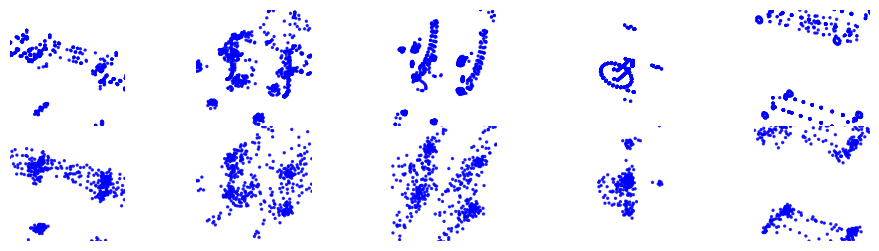

epoch 1038 train loss : 0.0034011805400950834 test loss : 0.007310275609294574 epoch time : 3.9844353199005127



In [15]:
  test_samples = next(iter(test_loader))
loss , test_output = test_batch(test_samples)
utils.plotPCbatch(test_samples,test_output)

print(writeString)

plt.show()


#torch.save(net.state_dict(), '/home/lee-ostadi/me1stnet.pth')


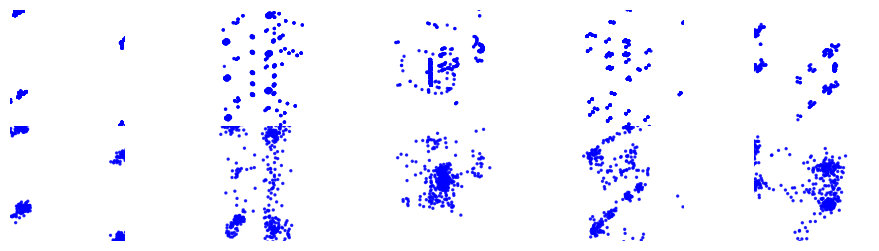

epoch 1038 train loss : 0.0034011805400950834 test loss : 0.007310275609294574 epoch time : 3.9844353199005127



In [19]:
train_samples = next(iter(train_loader))
loss , train_output = test_batch(train_samples)
utils.plotPCbatch(train_samples, train_output)
print(writeString)

plt.show()
